#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 설치 및 불러오기

* 라이브러리 로딩

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [9]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [74]:
data = pd.read_csv(path + 'data01_train.csv')
features = pd.read_csv(path + 'features.csv')

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [19]:
data.shape

(5881, 563)

In [20]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [21]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [23]:
data.isna().sum()

,0
tBodyAcc-mean()-X,0
tBodyAcc-mean()-Y,0
tBodyAcc-mean()-Z,0
tBodyAcc-std()-X,0
tBodyAcc-std()-Y,0
...,...
"angle(X,gravityMean)",0
"angle(Y,gravityMean)",0
"angle(Z,gravityMean)",0
subject,0


In [24]:
data.isna().sum().sum()

0

In [22]:
features.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [75]:
df = data

In [27]:
target = 'Activity'

In [28]:
# 범주의 종류 확인
categories = df[target].unique()

# 범주별 빈도수 계산
category_counts = df[target].value_counts()

# 범주별 비율 계산
category_percentage = df[target].value_counts(normalize=True) * 100

# 결과 출력
print("범주의 종류:")
print(categories)

print("\n범주별 빈도수:")
print(category_counts)

print("\n범주별 비율(%):")
print(category_percentage)

범주의 종류:
['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']

범주별 빈도수:
Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

범주별 비율(%):
Activity
LAYING                18.959361
STANDING              18.483251
SITTING               17.548036
WALKING               16.969903
WALKING_UPSTAIRS      14.589356
WALKING_DOWNSTAIRS    13.450094
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


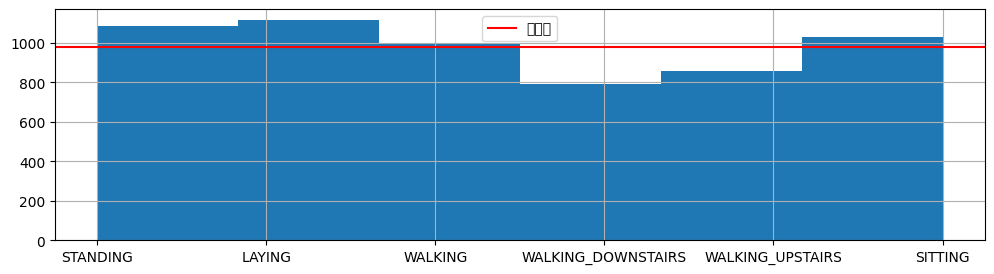

In [32]:
plt.figure(figsize=(12,3))
plt.hist(df[target], bins=6)
plt.axhline(df[target].value_counts().mean(), color='r', label='평균값')
plt.legend()
plt.grid()
plt.show()

### 삭제 - (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [33]:
from sklearn.model_selection import train_test_split

In [76]:
# 데이터 전처리 함수

def pre_function(df, target, do_split=False, test_split_ratio=0.2):
  '''
  input
  - df : dataframe - 전처리할 데이터프레임
  - target : string - 타겟 변수명 (예: 'Activity')
  - do_split : boolean - True일 경우, 'subject'에 기반한 데이터 분할을 수행 (주어진 split_ratio에 따라), False일 경우, train_test_split을 사용하여 무작위로 분할합니다.
  - test_split_ratio : float - 데이터 분할 비율. default는 0.2로 설정되어 있으며, 이 비율로 데이터를 분할 (기본적으로 80% 훈련 데이터, 20% 검증 데이터)합니다.

  output
  - x_train : 분할된 훈련 데이터의 feature (입력 데이터) 입니다.
  - x_val : 분할된 검증 데이터의 feature (입력 데이터) 입니다.
  - y_train : 분할된 훈련 데이터의 target (타겟 데이터) 입니다.
  - y_val : 분할된 검증 데이터의 target (타겟 데이터) 입니다.

  Description
  - 이 함수는 데이터를 전처리한 후, 'do_split' 옵션에 따라, 'subject'를 기준으로 데이터를 분할하거나, train_test_split을 사용해 무작위로 데이터를 분할할 수 있습니다.
  - 'Activity'는 0~5로 매핑되고, 동적/정적 활동에 따라 'is_dynamic' 변수를 생성합니다.
  '''

  # activity_map = {
  #     'SITTING': 0,
  #     'STANDING': 1,
  #     'LAYING': 2,
  #     'WALKING': 3,
  #     'WALKING_UPSTAIRS': 4,
  #     'WALKING_DOWNSTAIRS': 5
  # }

  # df['Activity'] = df['Activity'].map(activity_map)

  df['is_dynamic'] = df['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

  # case 1 - split 적용시
  if do_split:
    x_train = df[df['subject'] <= int(df['subject'].max() * (1 - test_split_ratio))].drop(columns=['Activity', 'subject', 'is_dynamic'])
    y_train = df[df['subject'] <= int(df['subject'].max() * (1 - test_split_ratio))][target]

    x_val = df[df['subject'] > int(df['subject'].max() * (1 - test_split_ratio))].drop(columns=['Activity', 'subject', 'is_dynamic'])
    y_val = df[df['subject'] > int(df['subject'].max() * (1 - test_split_ratio))][target]

    x_train.reset_index(drop=True, inplace=True)
    x_val.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)

    return x_train, x_val, y_train, y_val

  # case 2 - split 미적용시
  else:
    x = df.drop(['Activity', 'subject', 'is_dynamic'], axis=1)
    y = df.loc[:, target]

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_split_ratio, random_state=1004)
    return x_train, x_val, y_train, y_val

In [78]:
x_train, x_val, y_train, y_val = pre_function(df, 'Activity', False, 0.2)

In [79]:
x_train_sub, x_val_sub, y_train_sub, y_val_sub = pre_function(df, 'Activity', True, 0.2)

#### 2) 모델링

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [80]:
# 모델링 함수

def rf_function(x_train, x_val, y_train, y_val):
  '''
  input
  - x_train : DataFrame - 훈련 데이터의 feature (입력 변수)
  - x_val : DataFrame - 검증 데이터의 feature (입력 변수)
  - y_train : Series or DataFrame - 훈련 데이터의 target (타겟 변수)
  - y_val : Series or DataFrame - 검증 데이터의 target (타겟 변수)

  output
  - rf_model : RandomForestClassifier - 학습된 랜덤 포레스트 모델 객체

  Description
  - 이 함수는 RandomForestClassifier 모델을 사용하여 학습을 수행하고, 검증 데이터로 예측을 진행합니다.
  - 혼돈 행렬(confusion matrix), 분류 보고서(classification report), 정확도(accuracy)를 출력하여 모델 성능을 평가합니다.
  - 최종적으로 학습된 랜덤 포레스트 모델을 반환합니다.
  '''

  rf_model = RandomForestClassifier(random_state=1004)

  # 모델 학습
  rf_model.fit(x_train, y_train)

  # 검증 데이터로 예측
  y_pred = rf_model.predict(x_val)

  # 정확도 출력
  confusion = confusion_matrix(y_val, y_pred)
  report = classification_report(y_val, y_pred)
  accuracy = accuracy_score(y_val, y_pred)
  print("혼돈 행렬\n", confusion)
  print("분류 보고서\n", report)
  print("정확도\n", accuracy)

  return rf_model

In [81]:
rf_model = rf_function(x_train, x_val, y_train, y_val)

혼돈 행렬
 [[224   0   0   0   0   1]
 [  0 203   6   0   0   0]
 [  0   9 209   0   0   0]
 [  0   0   0 187   1   1]
 [  0   0   0   0 149   1]
 [  0   0   0   1   1 184]]
분류 보고서
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       225
           SITTING       0.96      0.97      0.96       209
          STANDING       0.97      0.96      0.97       218
           WALKING       0.99      0.99      0.99       189
WALKING_DOWNSTAIRS       0.99      0.99      0.99       150
  WALKING_UPSTAIRS       0.98      0.99      0.99       186

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177

정확도
 0.9821580288870009


In [82]:
rf_model_sub = rf_function(x_train_sub, x_val_sub, y_train_sub, y_val_sub)

혼돈 행렬
 [[337   0   0   0   0   0]
 [  0 288  28   0   0   0]
 [  0  53 293   0   0   0]
 [  0   0   0 282   0   0]
 [  0   0   0  17 204  38]
 [  0   0  19  12   4 225]]
분류 보고서
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       337
           SITTING       0.84      0.91      0.88       316
          STANDING       0.86      0.85      0.85       346
           WALKING       0.91      1.00      0.95       282
WALKING_DOWNSTAIRS       0.98      0.79      0.87       259
  WALKING_UPSTAIRS       0.86      0.87      0.86       260

          accuracy                           0.91      1800
         macro avg       0.91      0.90      0.90      1800
      weighted avg       0.91      0.91      0.90      1800

정확도
 0.905


#### 3) 변수 중요도 추출

In [85]:
importances = rf_model.feature_importances_
features = x_train.columns

importances_sub = rf_model_sub.feature_importances_
features_sub = x_train_sub.columns

In [89]:
feature_importance_df = plot_feature_importance(importances, features)

feature_importance_df_sub = plot_feature_importance(importances_sub, features_sub)

Output hidden; open in https://colab.research.google.com to view.

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [91]:
display(feature_importance_df.head())
display(feature_importance_df_sub.head())

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.041462
1,tGravityAcc-mean()-Y,0.028879
2,tGravityAcc-max()-X,0.027309
3,tGravityAcc-energy()-X,0.026017
4,tGravityAcc-mean()-X,0.025543


,feature_name,feature_importance
0,tGravityAcc-min()-X,0.045771
1,tGravityAcc-mean()-Y,0.030635
2,tGravityAcc-mean()-X,0.028688
3,tGravityAcc-max()-X,0.026545
4,tGravityAcc-max()-Y,0.025377


In [92]:
display(feature_importance_df.tail())
display(feature_importance_df_sub.tail())

,feature_name,feature_importance
556,"fBodyAccJerk-bandsEnergy()-57,64.1",0.000085
557,"fBodyAcc-bandsEnergy()-57,64",0.000083
558,fBodyAcc-iqr()-Y,0.000083
559,"fBodyAccJerk-bandsEnergy()-49,64",0.000072
560,fBodyAcc-maxInds-Z,0.000054


,feature_name,feature_importance
556,tGravityAccMag-arCoeff()4,0.000093
557,tBodyGyroMag-std(),0.000081
558,"fBodyAccJerk-bandsEnergy()-57,64.2",0.000080
559,fBodyAccJerk-min()-Y,0.000073
560,"tBodyAcc-arCoeff()-Z,1",0.000072


#### 2) 상위 5개 변수에 대한 분석

In [99]:
# 그래프 비교하여 그리기 위한 함수

def plot_kde_comparison(features_left, features_right, df, target):
    """
    두 개의 특성 리스트에 대해 각각 KDE 플롯을 그려주는 함수

    Parameters:
    - features_left: 왼쪽 플롯에 표시할 특성 리스트
    - features_right: 오른쪽 플롯에 표시할 특성 리스트
    - df: 데이터프레임
    - target: 타겟 변수명 (분류 기준으로 사용)
    """
    for feature_left, feature_right in zip(features_left, features_right):
        # 각각의 figure를 생성하고 크기 설정
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # 왼쪽 그래프 (features_left)
        sns.kdeplot(data=df, x=feature_left, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[0])
        axes[0].set_title(f"KDE Plot of {feature_left} by {target}")
        axes[0].set_xlabel(feature_left)
        axes[0].set_ylabel('Density')

        # 오른쪽 그래프 (features_right)
        sns.kdeplot(data=df, x=feature_right, hue=target, fill=True, common_norm=False, alpha=0.5, ax=axes[1])
        axes[1].set_title(f"KDE Plot of {feature_right} by {target}")
        axes[1].set_xlabel(feature_right)
        axes[1].set_ylabel('Density')

        # 그래프 간격 조정 및 출력
        plt.tight_layout()
        plt.show()

In [105]:
top5_features = feature_importance_df['feature_name'].head(5)
display(top5_features)

top5_features_sub = feature_importance_df_sub['feature_name'].head(5)
display(top5_features_sub)

,feature_name
0,tGravityAcc-min()-X
1,tGravityAcc-mean()-Y
2,tGravityAcc-max()-X
3,tGravityAcc-energy()-X
4,tGravityAcc-mean()-X


,feature_name
0,tGravityAcc-min()-X
1,tGravityAcc-mean()-Y
2,tGravityAcc-mean()-X
3,tGravityAcc-max()-X
4,tGravityAcc-max()-Y


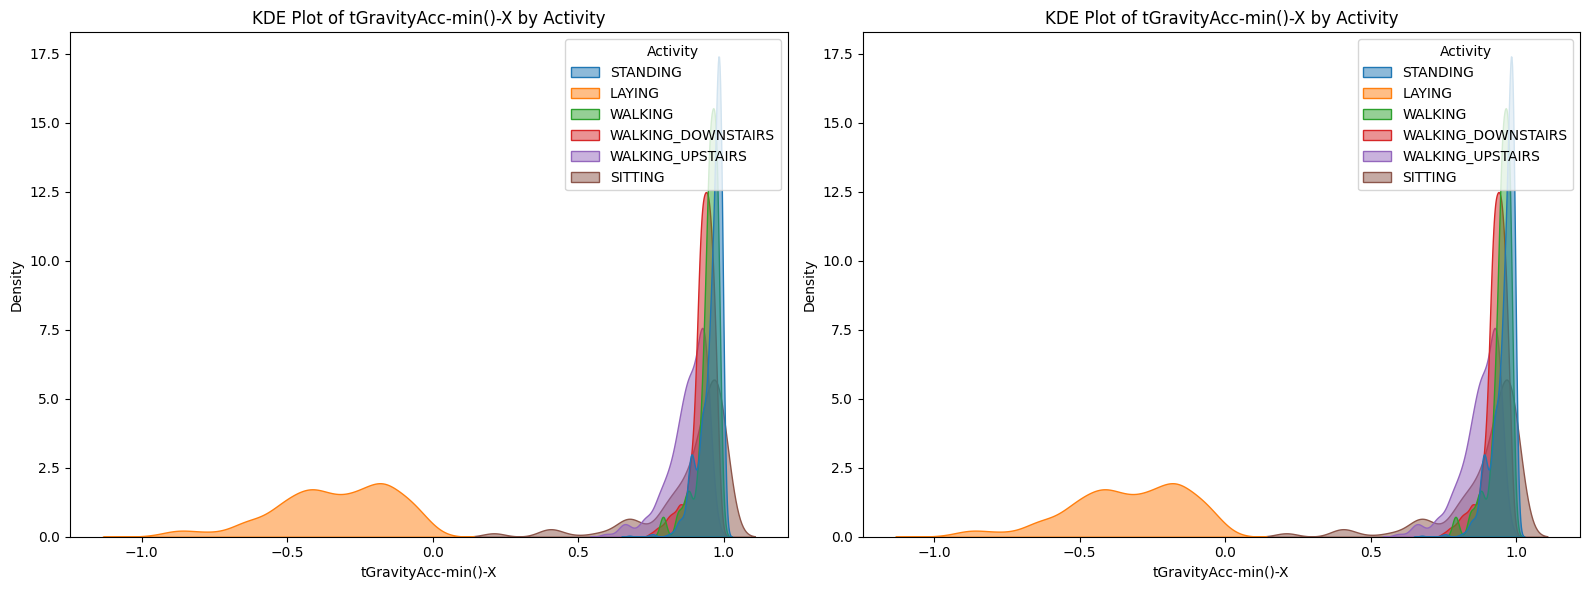

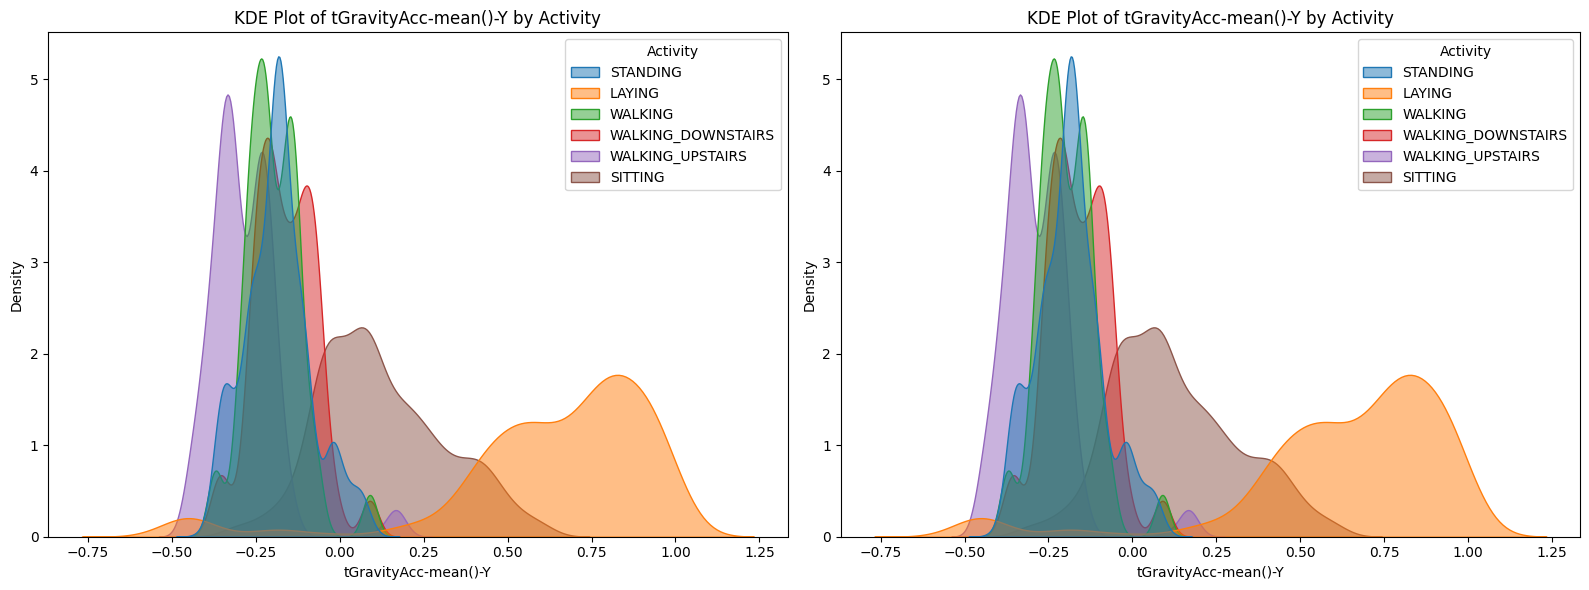

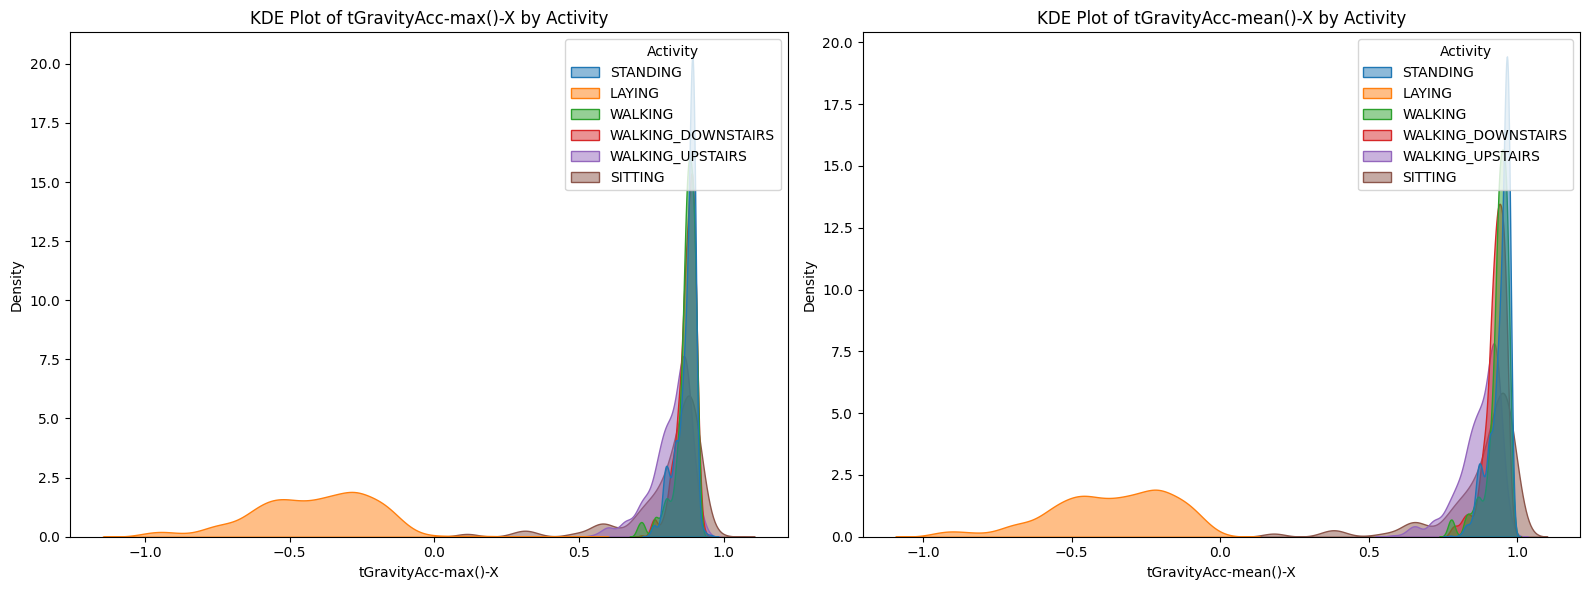

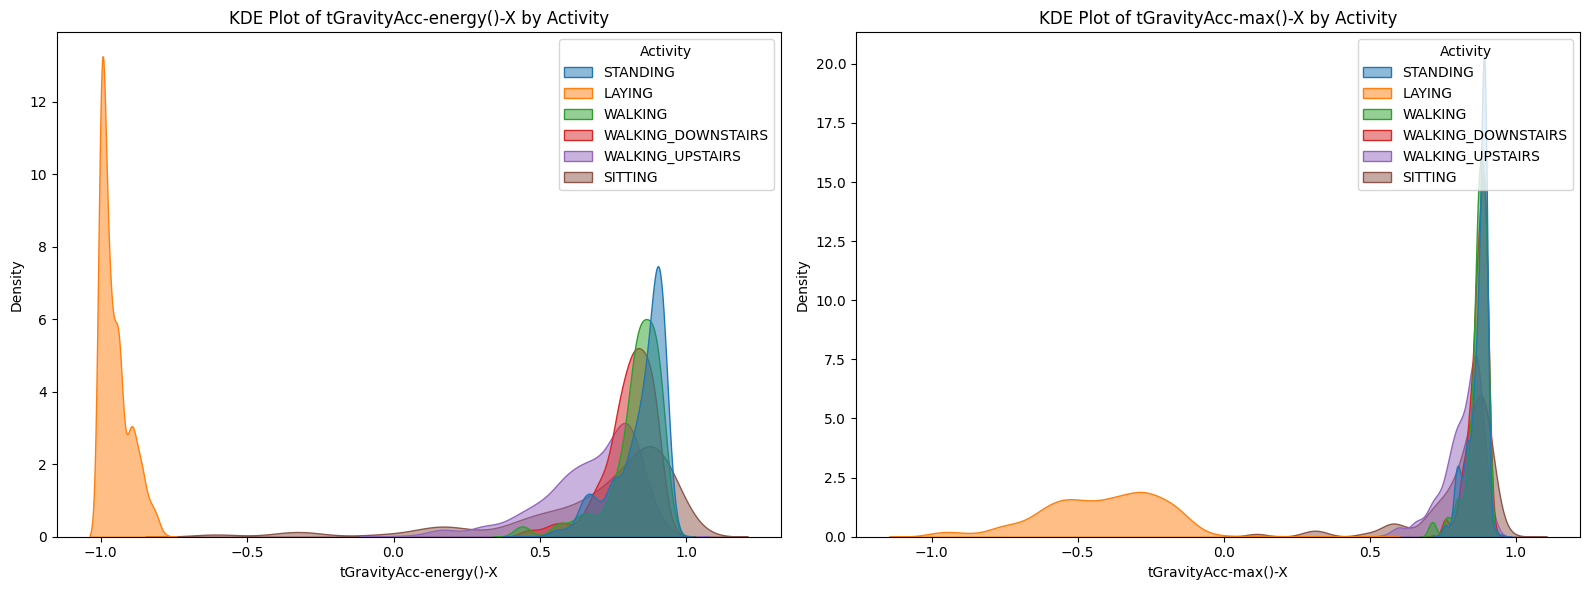

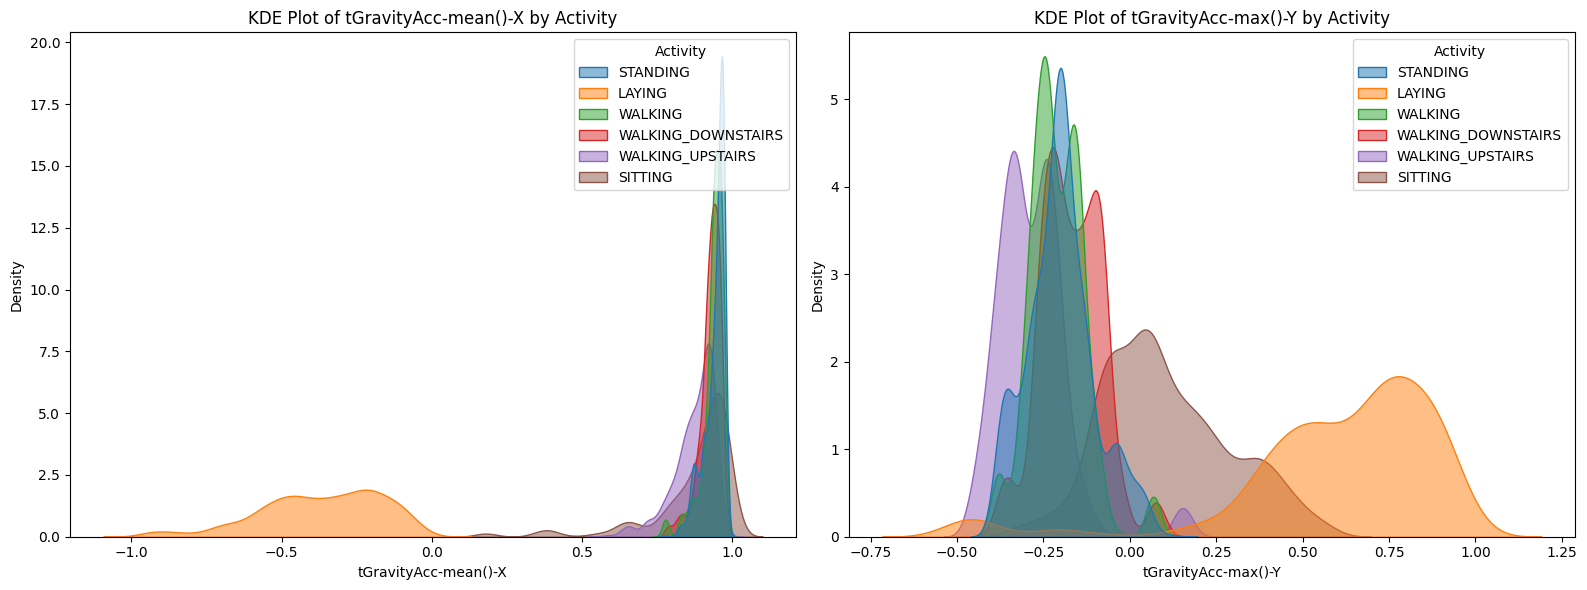

In [106]:
plot_kde_comparison(top5_features, top5_features_sub, df, 'Activity')

#### 3) 하위 5개 변수에 대한 분석

In [107]:
bottom5_features = feature_importance_df['feature_name'].tail(5).iloc[::-1].reset_index(drop=True)
display(bottom5_features)

bottom5_features_sub = feature_importance_df_sub['feature_name'].tail(5).iloc[::-1].reset_index(drop=True)
display(bottom5_features_sub)

,feature_name
0,fBodyAcc-maxInds-Z
1,"fBodyAccJerk-bandsEnergy()-49,64"
2,fBodyAcc-iqr()-Y
3,"fBodyAcc-bandsEnergy()-57,64"
4,"fBodyAccJerk-bandsEnergy()-57,64.1"


,feature_name
0,"tBodyAcc-arCoeff()-Z,1"
1,fBodyAccJerk-min()-Y
2,"fBodyAccJerk-bandsEnergy()-57,64.2"
3,tBodyGyroMag-std()
4,tGravityAccMag-arCoeff()4


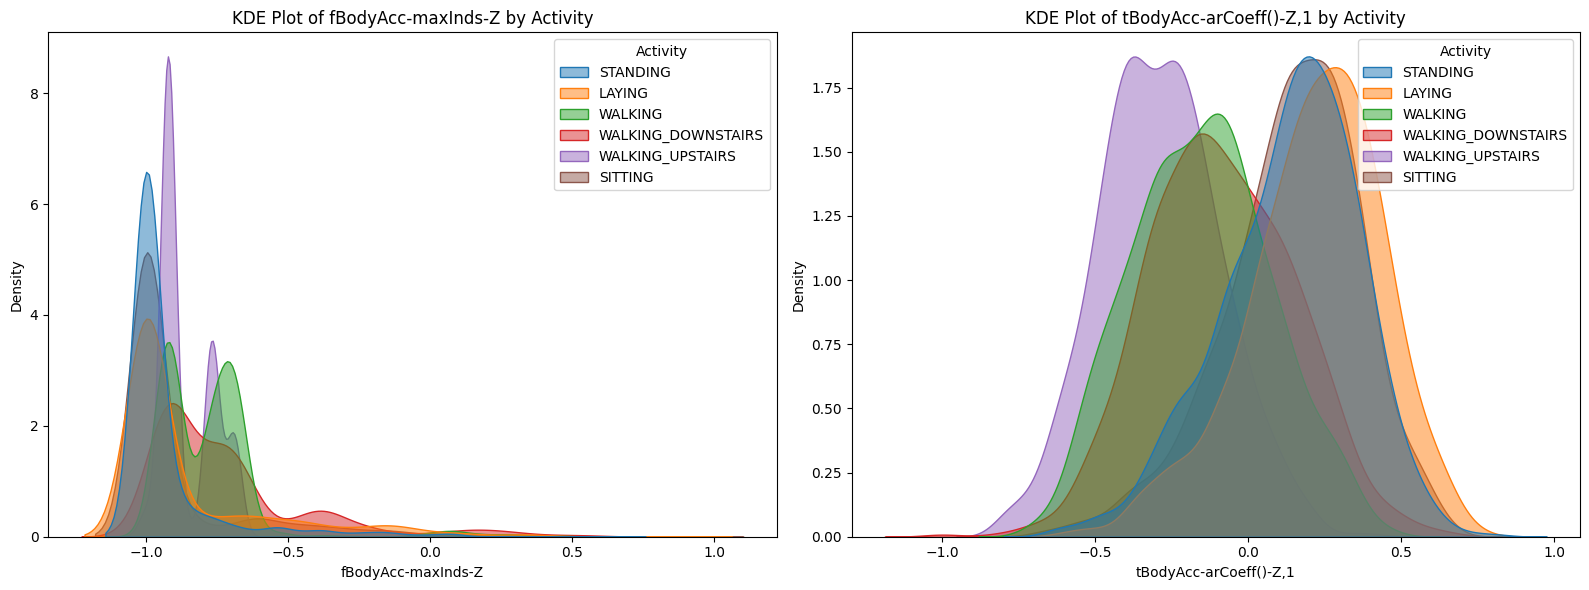

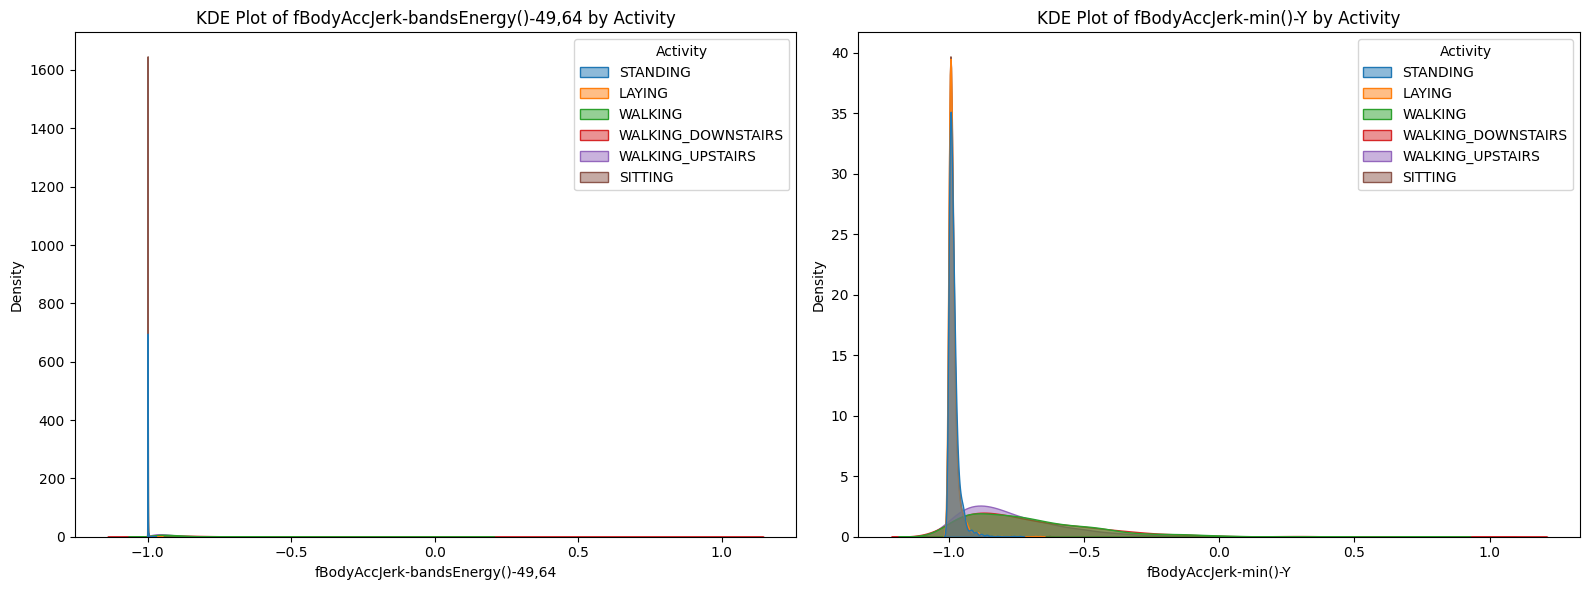

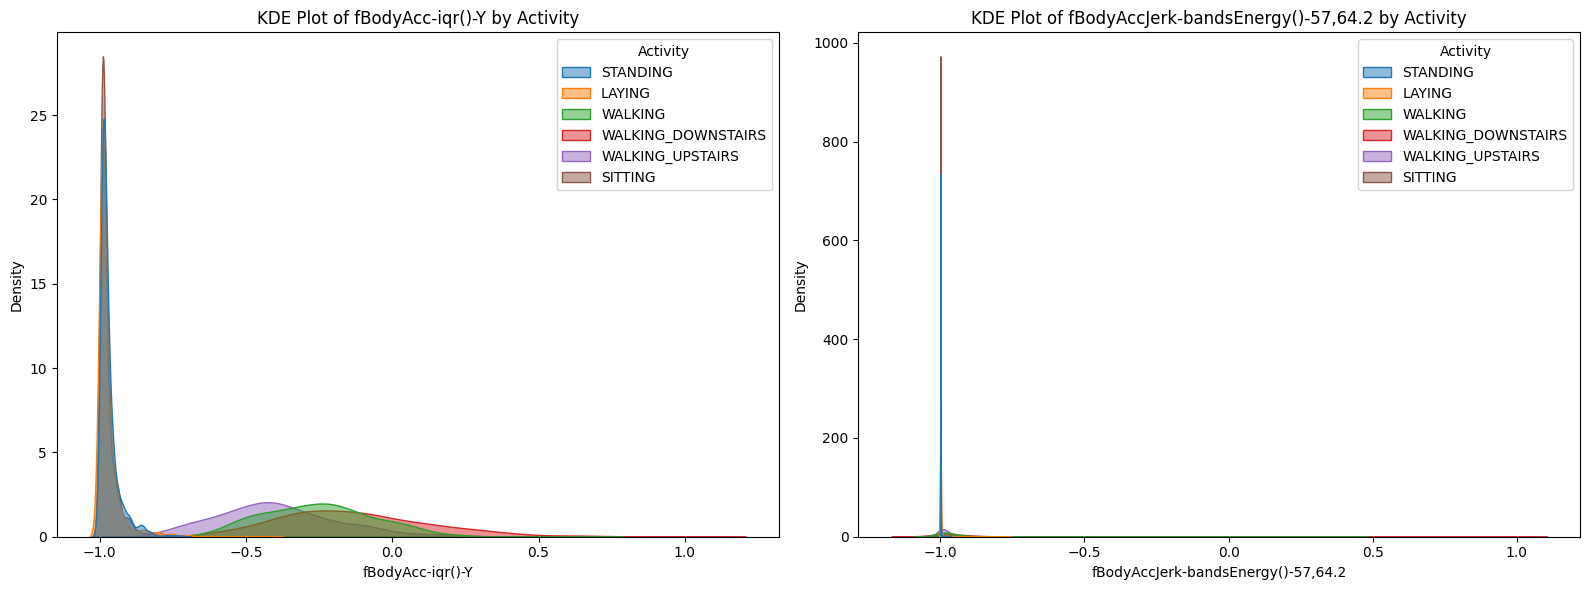

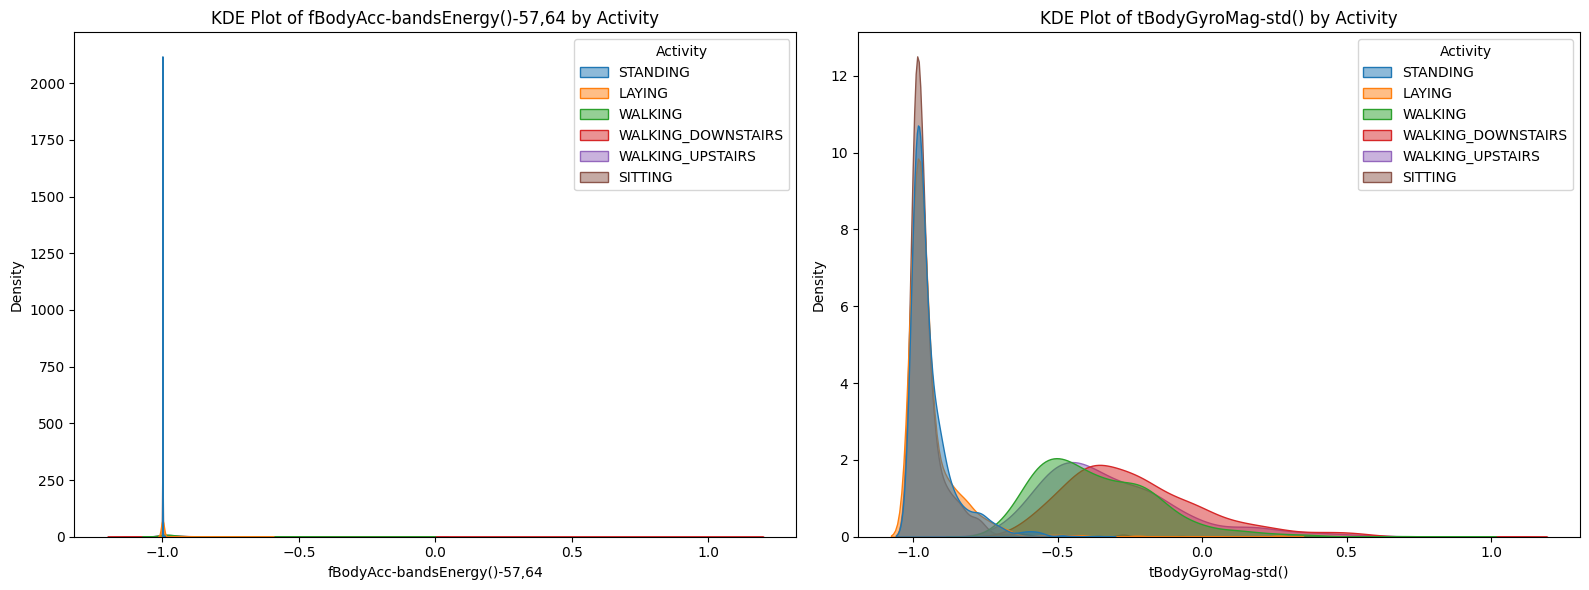

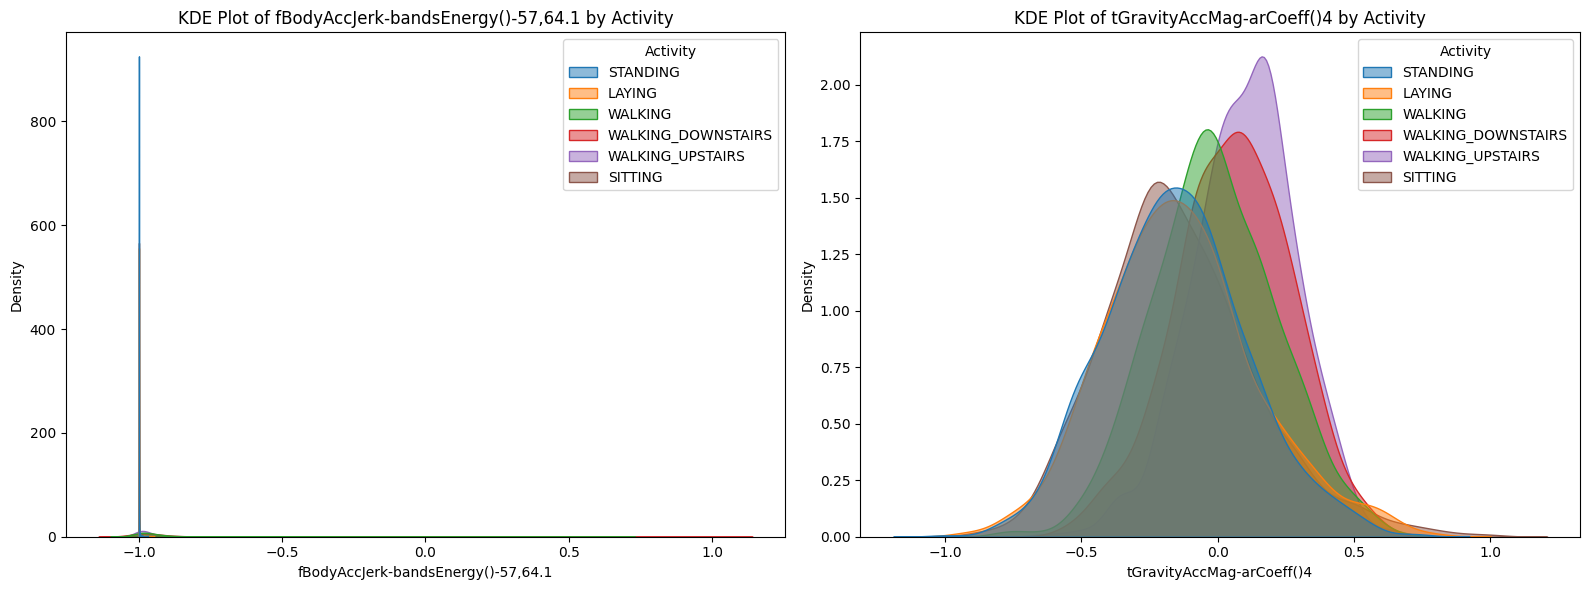

In [108]:
plot_kde_comparison(bottom5_features, bottom5_features_sub, df, 'Activity')

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [98]:
# def pre_function(df, target, do_split=False, test_split_ratio=0.2) 함수 내에 is_dynamic를 추가하였습니다.

#### 2) 기본모델 생성

In [109]:
x_train_dy, x_val_dy, y_train_dy, y_val_dy = pre_function(df, 'is_dynamic', False, 0.2)
x_train_dy_sub, x_val_dy_sub, y_train_dy_sub, y_val_dy_sub = pre_function(df, 'is_dynamic', True, 0.2)

In [110]:
rf_model_dy = rf_function(x_train_dy, x_val_dy, y_train_dy, y_val_dy)
rf_model_dy_sub = rf_function(x_train_dy_sub, x_val_dy_sub, y_train_dy_sub, y_val_dy_sub)

혼돈 행렬
 [[651   1]
 [  0 525]]
분류 보고서
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       652
           1       1.00      1.00      1.00       525

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

정확도
 0.9991503823279524
혼돈 행렬
 [[999   0]
 [ 27 774]]
분류 보고서
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       999
           1       1.00      0.97      0.98       801

    accuracy                           0.98      1800
   macro avg       0.99      0.98      0.98      1800
weighted avg       0.99      0.98      0.98      1800

정확도
 0.985


In [111]:
importances_dy = rf_model_dy.feature_importances_
features_dy = x_train_dy.columns

importances_dy_sub = rf_model_dy_sub.feature_importances_
features_dy_sub = x_train_dy_sub.columns

In [112]:
feature_importance_df_dy = plot_feature_importance(importances_dy, features_dy)

feature_importance_df_dy_sub = plot_feature_importance(importances_dy_sub, features_dy_sub)

Output hidden; open in https://colab.research.google.com to view.

#### 3) 변수중요도 상위 5개 분석

In [113]:
top5_features_dy = feature_importance_df_dy['feature_name'].head(5)
display(top5_features_dy)

top5_features_dy_sub = feature_importance_df_dy_sub['feature_name'].head(5)
display(top5_features_dy_sub)

,feature_name
0,tBodyAccJerk-sma()
1,"fBodyAccJerk-bandsEnergy()-1,16"
2,tBodyAccJerk-mad()-X
3,tBodyAccJerk-entropy()-X
4,fBodyAccJerk-std()-X


,feature_name
0,tBodyAccJerk-mad()-X
1,tBodyAccJerk-sma()
2,"fBodyAccJerk-bandsEnergy()-1,16"
3,tBodyAccJerk-iqr()-X
4,tBodyAccJerk-entropy()-X


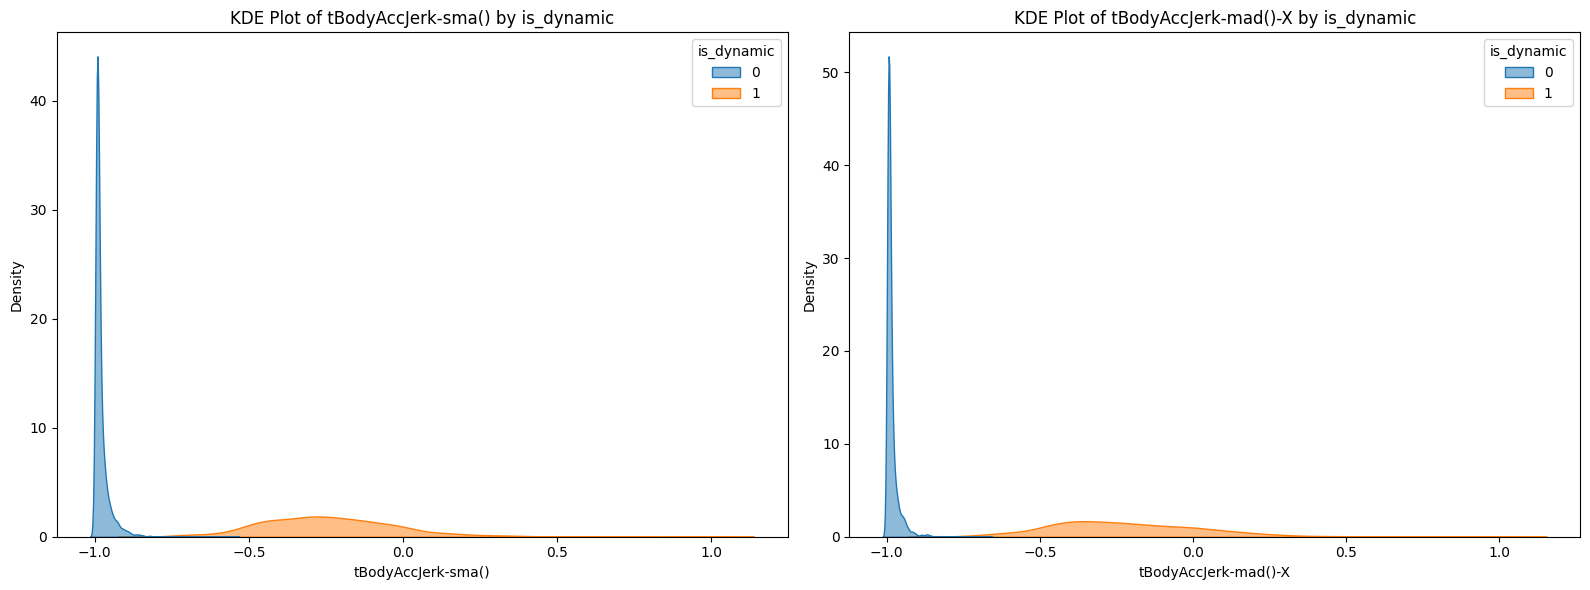

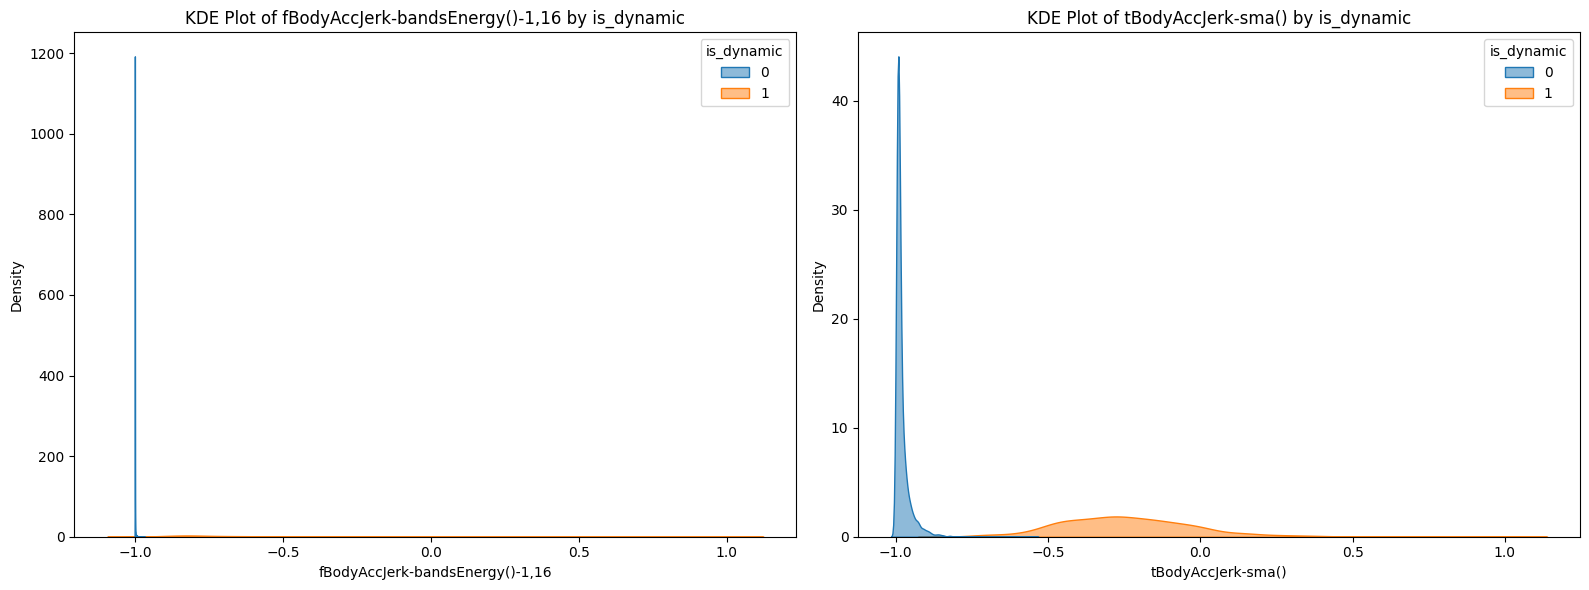

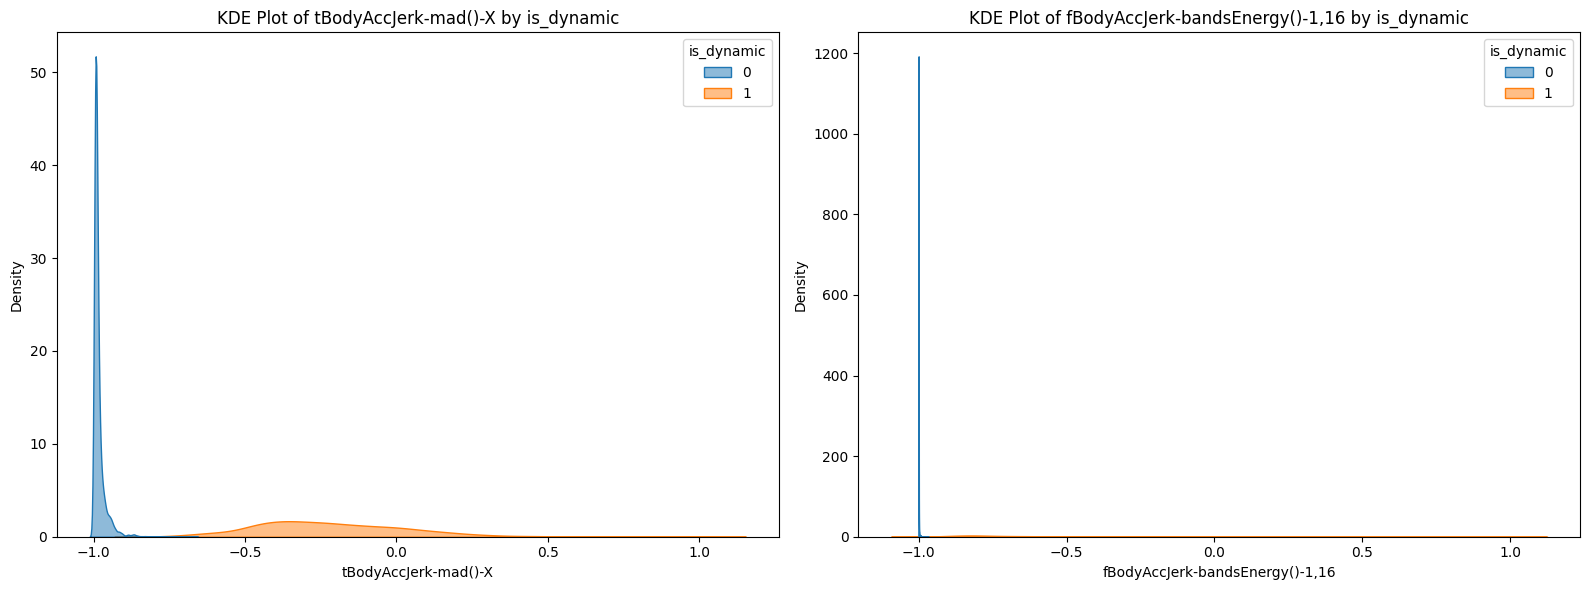

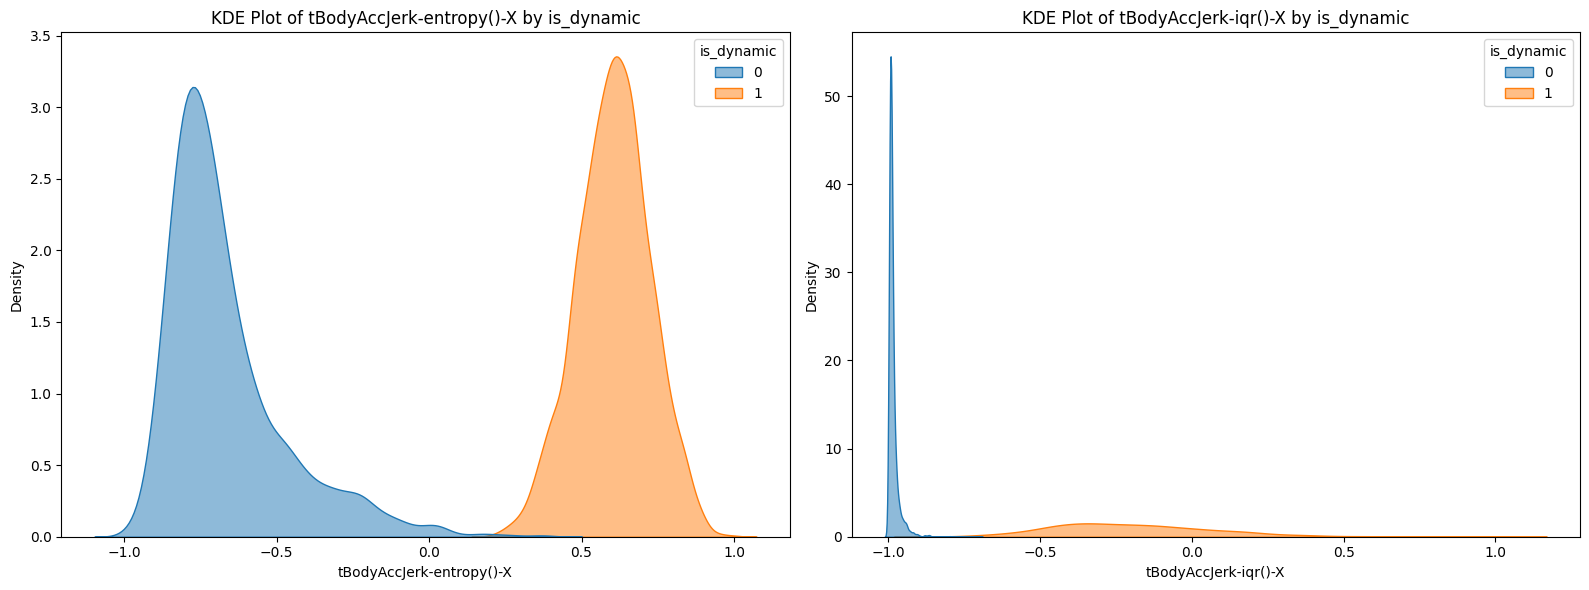

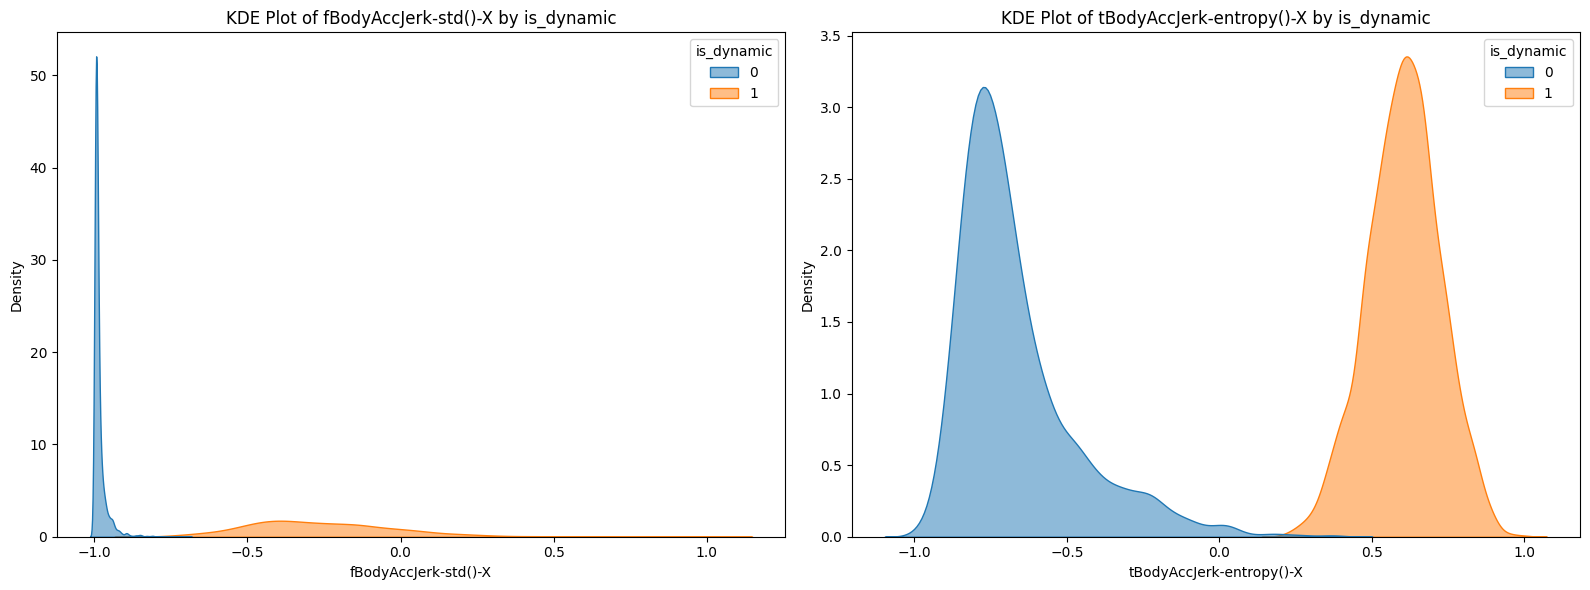

In [116]:
plot_kde_comparison(top5_features_dy, top5_features_dy_sub, df, 'is_dynamic')

#### 4) 변수중요도 하위 5개 분석

In [115]:
bottom5_features_dy = feature_importance_df_dy['feature_name'].tail(5).iloc[::-1].reset_index(drop=True)
display(bottom5_features_dy)

bottom5_features_dy_sub = feature_importance_df_dy_sub['feature_name'].tail(5).iloc[::-1].reset_index(drop=True)
display(bottom5_features_dy_sub)

,feature_name
0,"angle(Z,gravityMean)"
1,tBodyAccMag-energy()
2,tBodyAccMag-iqr()
3,tBodyAccMag-entropy()
4,tBodyAccMag-arCoeff()1


,feature_name
0,tBodyAcc-mean()-X
1,tGravityAccMag-arCoeff()2
2,tGravityAccMag-arCoeff()3
3,tGravityAccMag-arCoeff()4
4,"tBodyAcc-correlation()-X,Z"


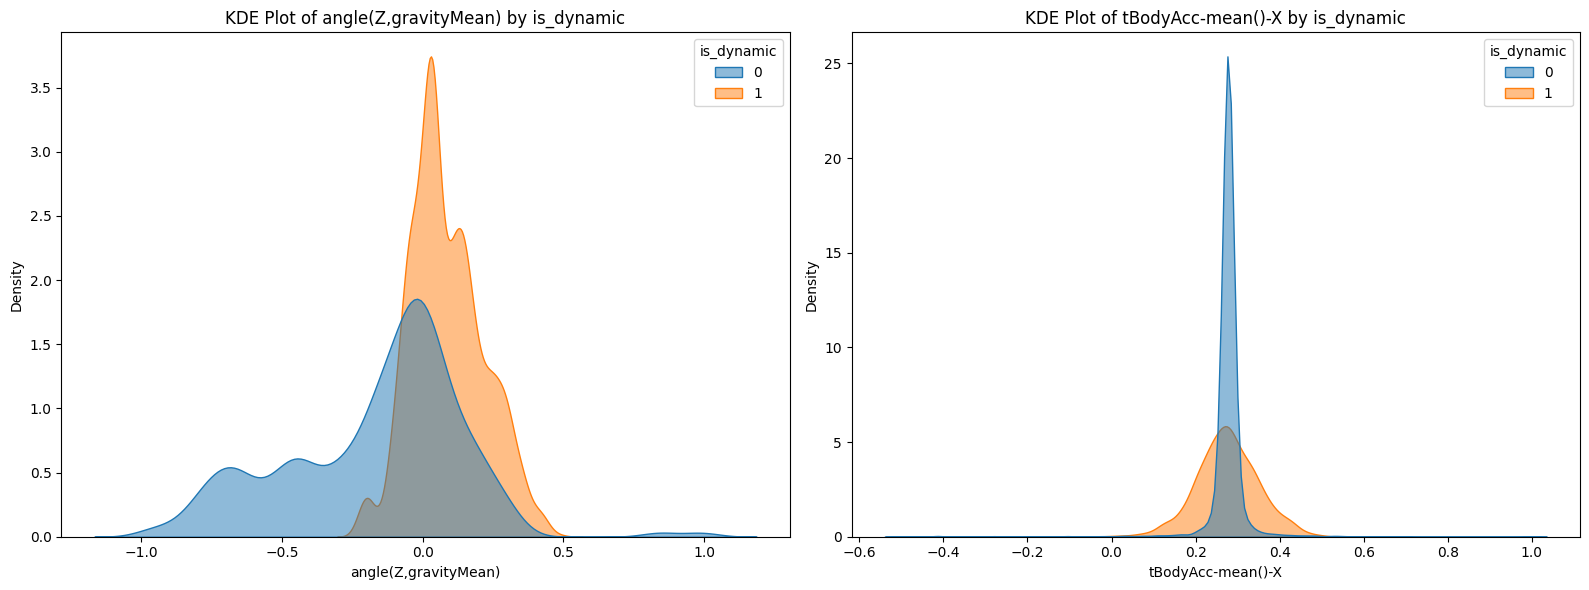

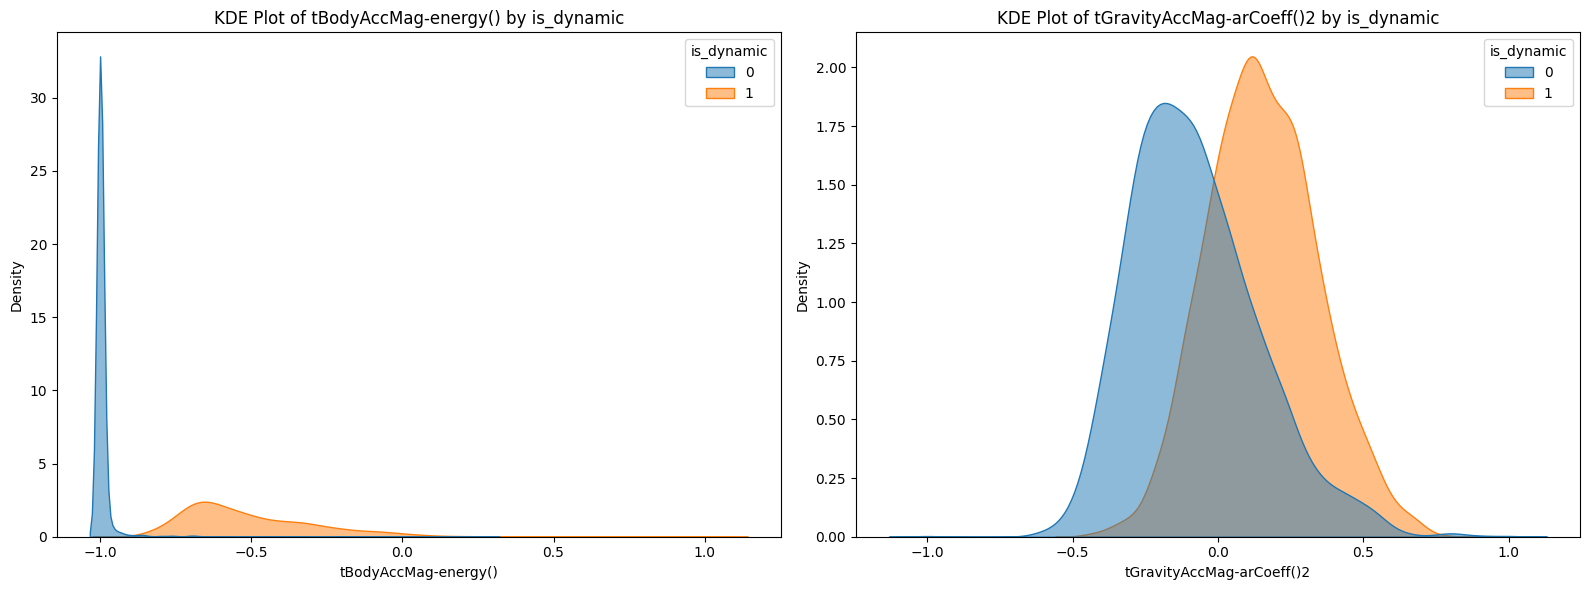

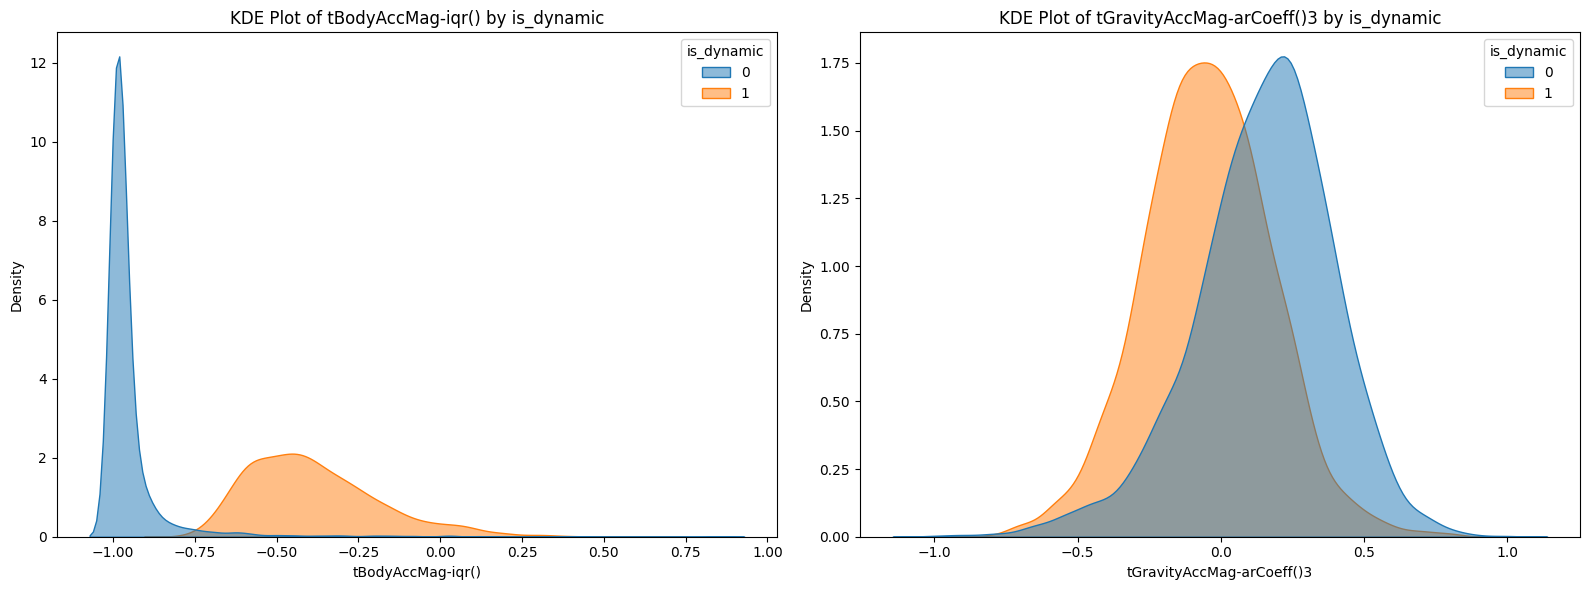

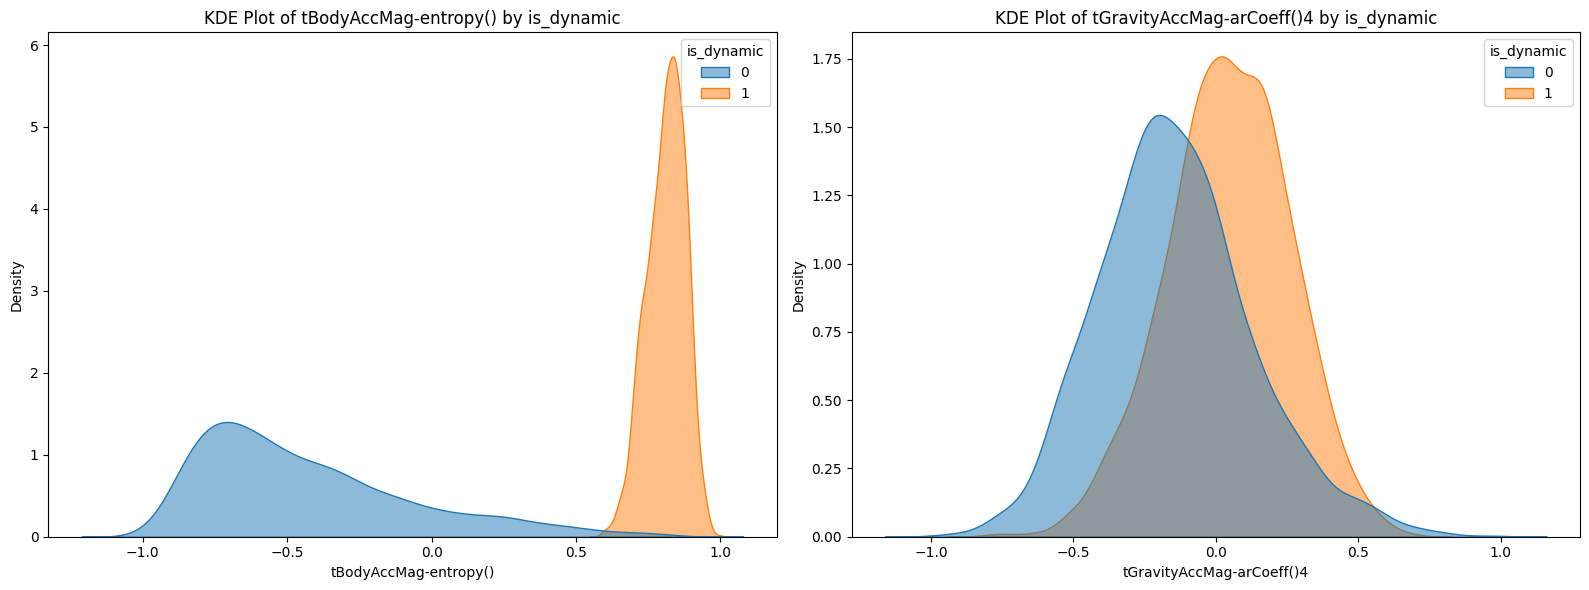

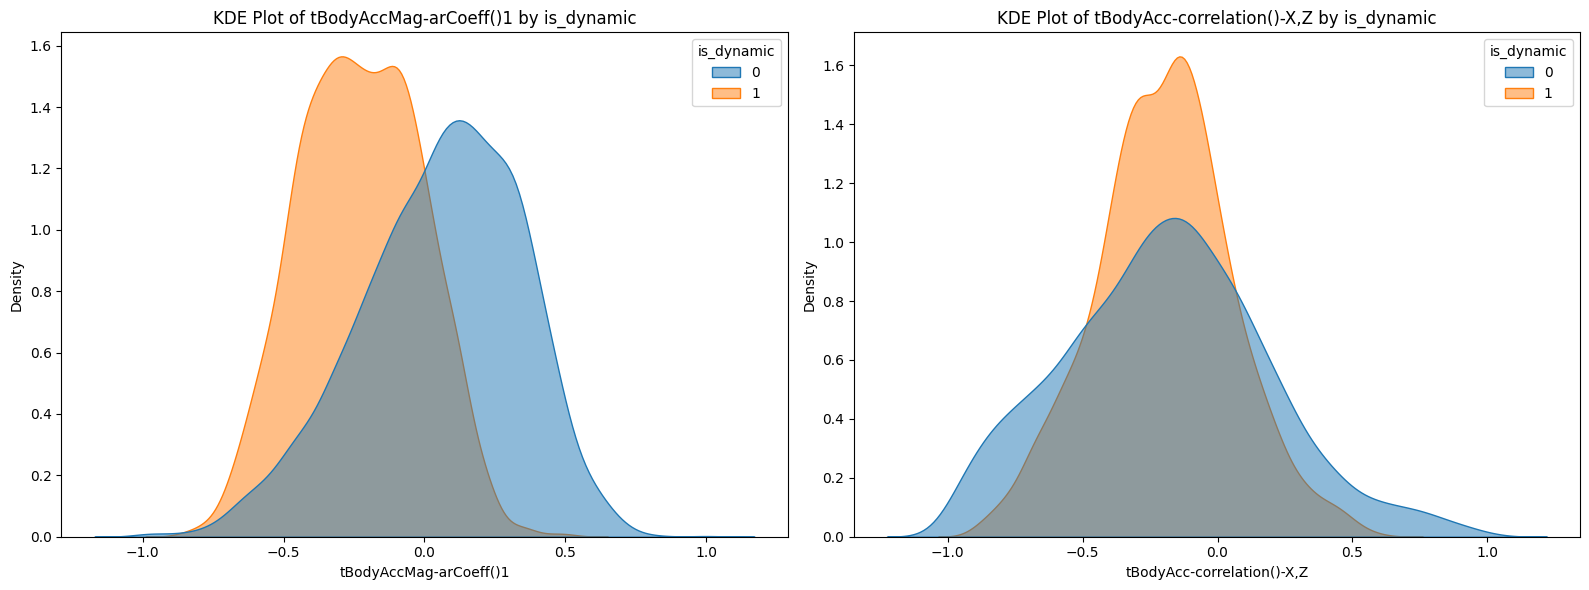

In [117]:
plot_kde_comparison(bottom5_features_dy, bottom5_features_dy_sub, df, 'is_dynamic')

## 삭제 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

#### 2) 합치기

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.